In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio   
import pickle
import scipy.signal
from tqdm.notebook import tqdm, trange
from scipy.special import erfc

from optic.comm.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp.core import firFilter, pulseShape, lowPassFIR, pnorm, upsample
from optic.comm.metrics import signal_power
from optic.plot import eyediagram
plt.rcParams["figure.figsize"] = (12,6)

-32767
32767


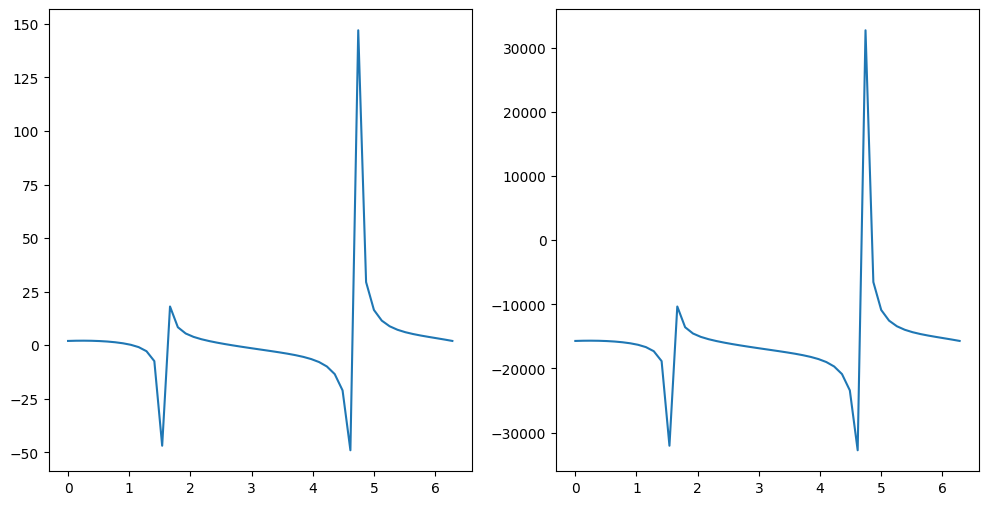

In [7]:
fig,axs = plt.subplots(1, 2)

x = np.linspace(0,2*np.pi)
y = np.sin(x)+2*np.cos(x) - x*np.tan(x)
axs[0].plot(x,y)

y = y - np.min(y)
y = y/np.max(y)*65534
y = y - 32767
y = (np.rint(y)).astype(int)
axs[1].plot(x,y)
print(min(y))
print(max(y))

In [36]:
#Valores Geração do sinal
M = 4 # order of the modulation format
nsimbolos = 1e6
SPS = 16
formatoPulso = 'nrz' #'rect','nrz','rrc'
nTaps = 1024
alpha = 0.1

#Valores DAC
sampleRate = 1e6
VHigh = 1
VLow = -1


# Geração de simbolos
bits = np.random.randint(0,2,int(nsimbolos*np.log2(M)))
#bits = np.array([0,0,0,0,0,1,0,1,1,0,1,0,1,1,0,1,1,1,1,0,1,1,0,0])
simbolos = modulateGray(bits, M, 'pam')
simbolos = pnorm(simbolos)

# Fomartação de pulso
simbolosup = upsample(simbolos, SPS)
pulso = pulseShape(formatoPulso, SPS, nTaps, alpha)
pulso = pulso/max(abs(pulso))
sinal = firFilter(pulso, simbolosup)
sinal = sinal.real
if formatoPulso == 'rrc':
    np.savez('Dados Gerador De sinal/Python/{}PAM_SPS={}_{}_alpha={}.npz'.format(int(M),int(SPS),formatoPulso,alpha), simbolos=simbolos,sinal=sinal)
else:
    np.savez('Dados Gerador De sinal/Python/{}PAM_SPS={}_{}.npz'.format(int(M),int(SPS),formatoPulso), simbolos=simbolos,sinal=sinal)

#npz = np.load('{}PAM_SPS={}_{}_aplha={}.npz'.format(int(M),int(SPS),formatoPulso,alpha))
#print(npz['simbolos'])

# Geração do arquivo do DAC
sinal = sinal - np.min(sinal)
sinal = sinal/np.max(sinal)*65534
sinal = sinal - 32767
sinal = (np.rint(sinal)).astype(int)

if formatoPulso == 'rrc':
    f = open('Dados Gerador De sinal/DAC/{}PAM_SPS={}_{}_aplha={}.arb'.format(int(M),int(SPS),formatoPulso,alpha), "w")
else:
    f = open('Dados Gerador De sinal/DAC/{}PAM_SPS={}_{}.arb'.format(int(M),int(SPS),formatoPulso), "w")

f.write('File Format:1.10\n')
f.write('Channel Count:1\n')
f.write('Sample Rate:{}\n'.format(int(sampleRate)))
f.write('High Level:{}\n'.format(int(VHigh)))
f.write('Low Level:{}\n'.format(int(VLow)))
f.write('Filter:"NORMAL"\n')
f.write('Data Points:{}\n'.format(int(len(sinal))))
f.write('Data:\n')
for i in range(len(sinal)-1):
    f.write('{}\n'.format(sinal[i]))
f.write('{}'.format(sinal[-1]))
f.close()

